Трифонов Максим ДЗ 1
Рассмотрим датасет б/у авто Германии [ссылка](https://www.kaggle.com/datasets/ander289386/cars-germany/data).

Описание датасета:
- **mileage** ––– пробег
- **make** ––– марка авто
- **model** ––– модель авто
- **fuel** ––– тип топлива
- **gear** ––– коробка передач
- **offerType**	–––	тип сделки (Used с пробегом, Pre-registered - Автомобиль, зарегистрированный на компанию или дилера, но фактически новый и неэксплуатировался; Demonstration - Автомобиль, используемый для демонстрации и тест-драйвов в автосалоне, также является фактически новым;
Employee's car - Автомобиль, принадлежавший сотруднику компании или дилера, может иметь небольшой пробег; New - новый)
- **price** ––– цена
- **hp** ––– мощность
- **year** ––– год выпуска


Мы хотим научиться предсказывать цену авто.
Подключим необходимые библиотеки

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Считываем выборку

In [2]:
df = pd.read_csv('autoscout24-germany-dataset.csv')

In [3]:
df.head()

,mileage,make,model,fuel,gear,offerType,price,hp,year
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011


In [4]:
df.isnull().sum()

mileage        0
make           0
model        143
fuel           0
gear         182
offerType      0
price          0
hp            29
year           0
dtype: int64

признаки model, gear, hp имеют пропущенные значения

Можем посмотреть среднюю цену авто

In [5]:
df['price'].mean()

16572.3372

## Анализ признаков

Все признаки важны для нахождения цены автомобиля. 

# Признак mileage


<Axes: xlabel='mileage', ylabel='price'>

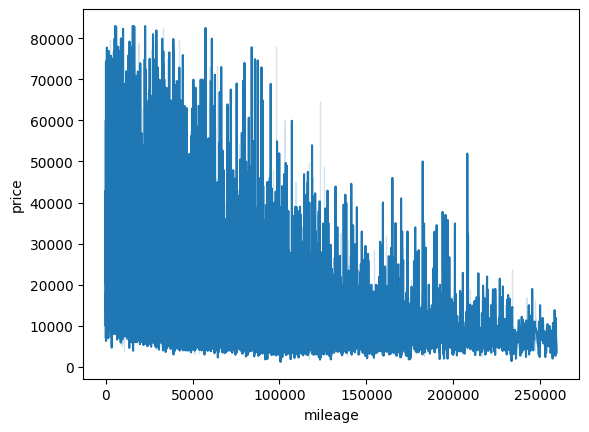

In [6]:
tmp = df[(df['mileage'] < df['mileage'].quantile(0.99)) & (df['price'] < df['price'].quantile(0.99))]
sns.lineplot(x = 'mileage', y = 'price', data=tmp)

Мы видим что предсказываемый признак цена, зависит от пробега. Чем больше пробег, тем ниже цена.

Можно узнать средний пробег



In [7]:
df['mileage'].mean()

71177.8641

# Признак make

<Axes: xlabel='make', ylabel='price'>

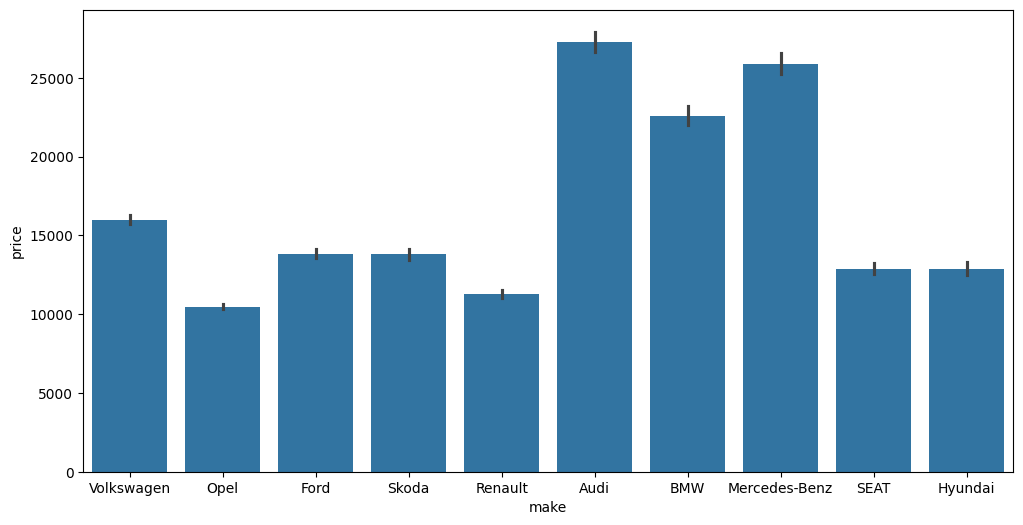

In [8]:
top_makes = tmp['make'].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.barplot(x='make', y='price', data=tmp[tmp['make'].isin(top_makes)], order=top_makes)

Мы видим что цена напрямую зависит от производителя авто. Премиальные марки естественно дороже.

# Признак model

Так же цена зависит и от модели авто, это не менее важно чем его марка. Тут у нас есть пропущенные значения, данных у нас много, а пропущенных значений мало и восстановить модель достаточно проблематично, поэтому можно их просто удалить.

In [9]:
df = df.dropna(subset=['model'])


In [10]:
df.isnull().sum()

mileage        0
make           0
model          0
fuel           0
gear         167
offerType      0
price          0
hp            26
year           0
dtype: int64

<Axes: xlabel='model', ylabel='price'>

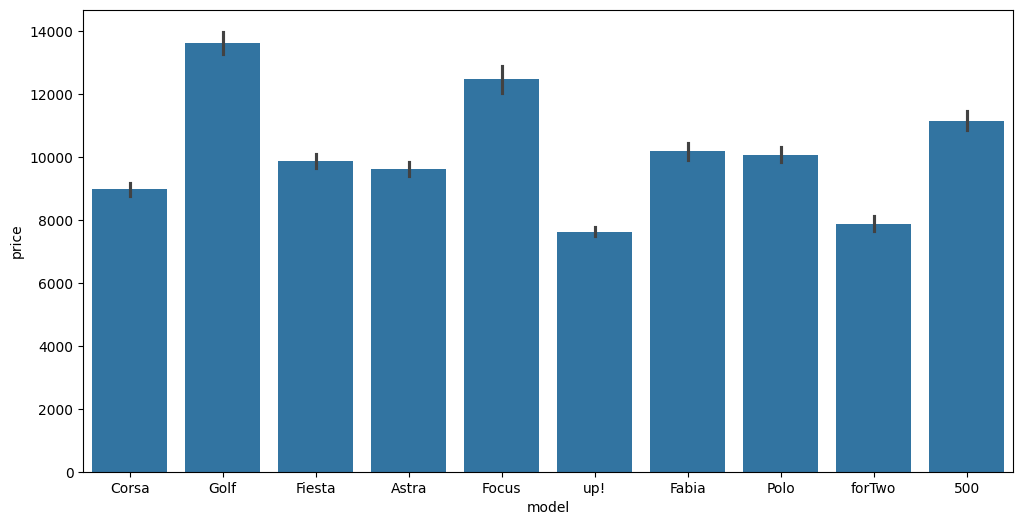

In [11]:
top_models = tmp['model'].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='price', data=tmp[tmp['model'].isin(top_models)], order=top_models)

Как и с марками, модель тоже напрямую влияет на цену авто.

# Признак gear

Тип КПП так же влияет на цену авто, но не очень сильно. Но мы оставим его, чтобы модель была точнее и восстановим отстутствующие значения. Тут это сделать не сложно, пропуски можно заполнить средним значением по модели т.к. даже если мы окажемся не правы, это не сильно исказит цену авто.

Для этого надо будет преобразовать значения. Automatic и semi-automatic мы сделаем 1, а manual сделаем 0.

In [12]:
gear_mapping = {
    'Manual': 0,
    'Automatic': 1,
    'Semi-automatic': 1
}
df['gear'] = df['gear'].map(gear_mapping)
gear_mean_by_model = df.groupby('model')['gear'].transform('mean')
df['gear'] = df['gear'].fillna(gear_mean_by_model.round())

In [13]:
df.isnull().sum()

mileage       0
make          0
model         0
fuel          0
gear          8
offerType     0
price         0
hp           26
year          0
dtype: int64

Осталось 8 пропусков. Это скорее всего какие то редкие модели, которые представленны в нашем датасете в единственном экземпляре.

In [14]:
df[df['gear'].isna()]


,mileage,make,model,fuel,gear,offerType,price,hp,year
3246,79000,Volkswagen,Pointer,Diesel,NaN,Used,6900,90.0,2016
5092,107130,Dodge,Nitro,Gasoline,NaN,Used,9700,260.0,2012
8967,79000,Volkswagen,Pointer,Diesel,NaN,Used,6900,90.0,2016
14604,38000,Tazzari,EV Zero Classic,Electric,NaN,Used,6500,20.0,2012
14675,312000,Trucks-Lkw,Ford,Diesel,NaN,Used,8200,131.0,2016
23700,128000,Volkswagen,Pointer,Diesel,NaN,Used,4850,75.0,2012
39762,2000,Caravans-Wohnm,Adria,-/- (Fuel),NaN,Used,24500,NaN,2016
46326,45,BMW,iX3,Electric,NaN,Used,58000,286.0,2021


Эти значения можно даже заполнить в ручную, т.к. пропусков осталось не много и можно проанализировать.

- Volkswagen Pointer они все скорее всего на механике т.к. это одна из самых бюджетных моделей.
- Dodge скорее всего на автомате, т.к. американские авто чаще всего идут на автомате.
- Tazzari на автомате, т.к. это электричка.
- Trucks-Lkw механика потому что это грузовик.
- Caravans-Wohnm это вообще прицеп дома на колесах, предлагаю его просто удалить.
- BMW автомат, тоже электричка.

In [15]:
df.loc[df['model'] == 'Pointer', 'gear'] = 0  
df.loc[df['model'] == 'Nitro', 'gear'] = 1  
df.loc[df['model'] == 'EV Zero Classic', 'gear'] = 1  
df.loc[df['model'] == 'Ford', 'gear'] = 0  
df.loc[df['model'] == 'iX3', 'gear'] = 1  
df = df[df['model'] != 'Adria']

In [16]:
df.isnull().sum()

mileage       0
make          0
model         0
fuel          0
gear          0
offerType     0
price         0
hp           25
year          0
dtype: int64

Все значения заполнены, можно посмотреть зависимость цены и типа коробки передач

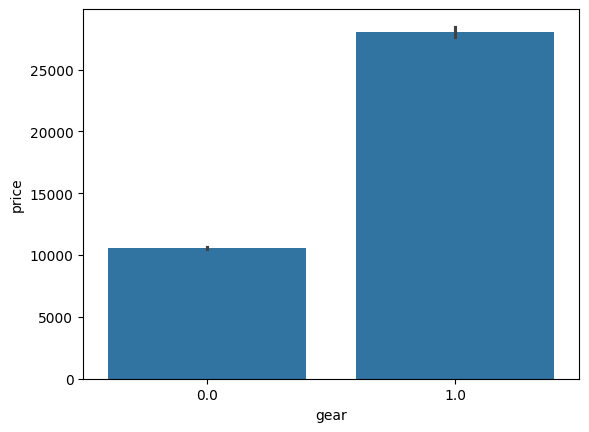

In [17]:
sns.barplot(x = "gear", y = "price", data = df);

Видим, что на механике авто обычно дешевле

# Признак hp и fuel

В этом признаке так же, есть пропущенные значения их не много, можно их восстановить и посмотреть зависимость цены от лошадинных сил.

In [18]:
df[df['hp'].isna()]

,mileage,make,model,fuel,gear,offerType,price,hp,year
482,36018,Mitsubishi,Space Star,Gasoline,0.0,Used,6222,NaN,2015
2368,36018,Mitsubishi,Space Star,Gasoline,0.0,Used,6222,NaN,2015
5552,129375,Peugeot,207,Gasoline,0.0,Used,5950,NaN,2013
5760,129375,Peugeot,207,Gasoline,0.0,Used,5950,NaN,2013
8892,71113,Opel,Corsa,Gasoline,0.0,Used,5666,NaN,2012
10575,72109,Ford,Fiesta,Gasoline,0.0,Used,6222,NaN,2013
10779,71113,Opel,Corsa,Gasoline,0.0,Used,5666,NaN,2012
10782,72109,Ford,Fiesta,Gasoline,0.0,Used,6222,NaN,2013
12000,139,Renault,Twingo,Electric,1.0,Demonstration,15990,NaN,2021
12549,46587,Opel,Corsa,-/- (Fuel),0.0,Used,7555,NaN,2015


Можно так же заполнить пропуск средним значением для каждой модели и типа топлива.

In [19]:
hp_mean_by_model_fuel = df.groupby(['model', 'fuel'])['hp'].transform('mean')
df['hp'] = df['hp'].fillna(hp_mean_by_model_fuel)

In [20]:
df[df['hp'].isna()]

,mileage,make,model,fuel,gear,offerType,price,hp,year
12549,46587,Opel,Corsa,-/- (Fuel),0.0,Used,7555,NaN,2015
14010,46587,Opel,Corsa,-/- (Fuel),0.0,Used,7555,NaN,2015
38049,999999,BMW,320,-/- (Fuel),1.0,Used,1999,NaN,2014
45923,10,Fiat,500C,Electric,1.0,Demonstration,36890,NaN,2021
45924,363,Fiat,500C,Electric,1.0,Demonstration,36890,NaN,2021


Видим что остались пропущенные значения, какое то значение в признаке fuel (-/- (Fuel)). Надо разобраться скорее всего это вместо пропуска.

In [21]:
df[df['fuel'] == '-/- (Fuel)']


,mileage,make,model,fuel,gear,offerType,price,hp,year
286,120500,Honda,Civic,-/- (Fuel),0.0,Used,8990,141.0,2014
303,53000,Skoda,Fabia,-/- (Fuel),0.0,Used,8990,110.0,2015
776,3500,Volkswagen,Passat,-/- (Fuel),1.0,Used,34900,156.0,2020
2986,110000,Ford,Fiesta,-/- (Fuel),1.0,Used,8900,101.0,2014
3661,49200,Hyundai,i30,-/- (Fuel),0.0,Used,9990,135.0,2015
3907,86000,Tesla,Model X,-/- (Fuel),1.0,Used,69700,562.0,2017
3908,86000,Tesla,Model X,-/- (Fuel),1.0,Used,69700,562.0,2017
4869,1500,Ford,Fiesta,-/- (Fuel),0.0,Used,14990,75.0,2021
7091,18521,Renault,ZOE,-/- (Fuel),1.0,Used,8995,92.0,2017
12131,83000,Skoda,Octavia,-/- (Fuel),0.0,Used,10900,110.0,2016


Видим, что таких значений немного, можно заодно их тоже заполнить.

Понятно что тесла это жлектричка, европейские производители скорее всего дизель, другие бензин.

In [22]:
df.loc[df['make'] == 'Tesla', 'fuel'] = 'Electric'  
df.loc[(df['make'] == 'Opel') & (df['fuel'] == '-/- (Fuel)'), 'fuel'] = 'Diesel'
df.loc[(df['make'] == 'Honda') & (df['fuel'] == '-/- (Fuel)'), 'fuel'] = 'Gasoline'
df.loc[(df['make'] == 'Volkswagen') & (df['fuel'] == '-/- (Fuel)') & (df['model'] == 'up!'), 'fuel'] = 'LPG'
df.loc[(df['make'] == 'Ford') & (df['fuel'] == '-/- (Fuel)'), 'fuel'] = 'Gasoline'
df.loc[(df['make'] == 'Hyundai') & (df['fuel'] == '-/- (Fuel)'), 'fuel'] = 'Gasoline'
df.loc[(df['make'] == 'Nissan') & (df['fuel'] == '-/- (Fuel)'), 'fuel'] = 'Gasoline'
df.loc[(df['make'] == 'Fiat') & (df['fuel'] == '-/- (Fuel)'), 'fuel'] = 'Diesel'
df.loc[(df['make'] == 'Renault') & (df['fuel'] == '-/- (Fuel)'), 'fuel'] = 'Diesel'
df.loc[(df['make'] == 'Volkswagen') & (df['fuel'] == '-/- (Fuel)'), 'fuel'] = 'Diesel'
df.loc[(df['make'] == 'Abarth') & (df['fuel'] == '-/- (Fuel)'), 'fuel'] = 'Gasoline'
df.loc[(df['make'] == 'BMW') & (df['fuel'] == '-/- (Fuel)'), 'fuel'] = 'Diesel'
df.loc[(df['make'] == 'Skoda') & (df['fuel'] == '-/- (Fuel)'), 'fuel'] = 'Gasoline'

Пропуски заполнены, теперь надо восстановить данные по мощности.

In [23]:
hp_mean_by_model_fuel = df.groupby(['model', 'fuel'])['hp'].transform('mean')
df['hp'] = df['hp'].fillna(hp_mean_by_model_fuel)

In [24]:
df[df['hp'].isna()]

,mileage,make,model,fuel,gear,offerType,price,hp,year
45923,10,Fiat,500C,Electric,1.0,Demonstration,36890,NaN,2021
45924,363,Fiat,500C,Electric,1.0,Demonstration,36890,NaN,2021


Нету данных только по фиату, их можно посмотреть в интернете.

In [25]:
df.loc[(df['make'] == 'Fiat') & (df['hp'].isna()), 'hp'] = 70

In [26]:
df.isnull().sum()

mileage      0
make         0
model        0
fuel         0
gear         0
offerType    0
price        0
hp           0
year         0
dtype: int64

Все пропуски заполненны.

<Axes: xlabel='hp', ylabel='price'>

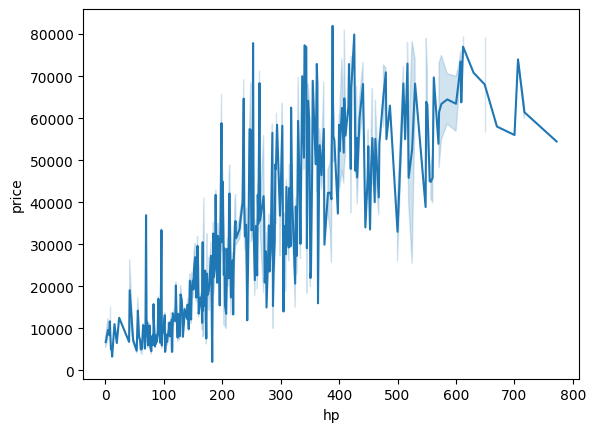

In [27]:
tmp = df[(df['price'] < df['price'].quantile(0.99))]
sns.lineplot(x = 'hp', y = 'price', data=tmp)

Чем больше мощность, тем выше цена

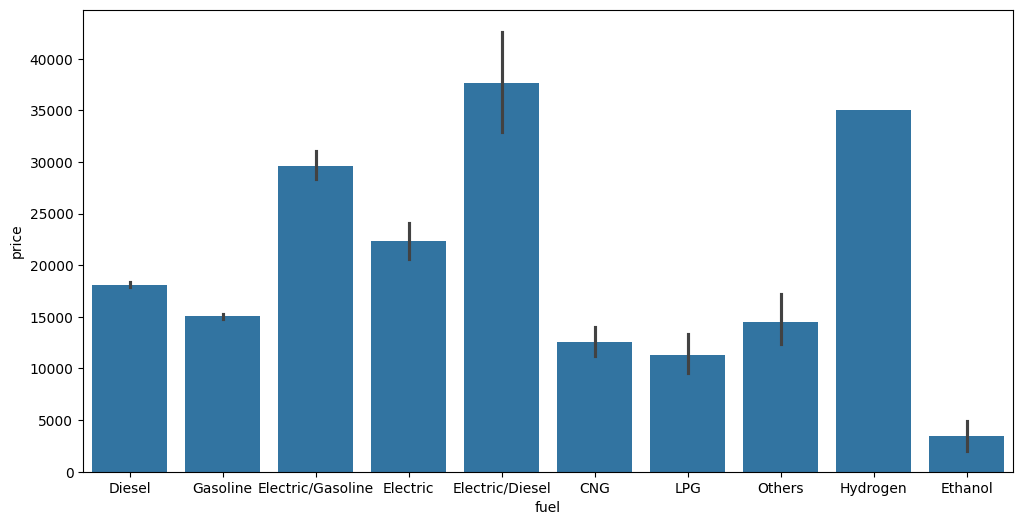

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(x = "fuel", y = "price", data = df);

Так же тип топлива влияет на цену

## Корреляция признаков

Так как есть признаки со строками, придется закодировать эти признаки

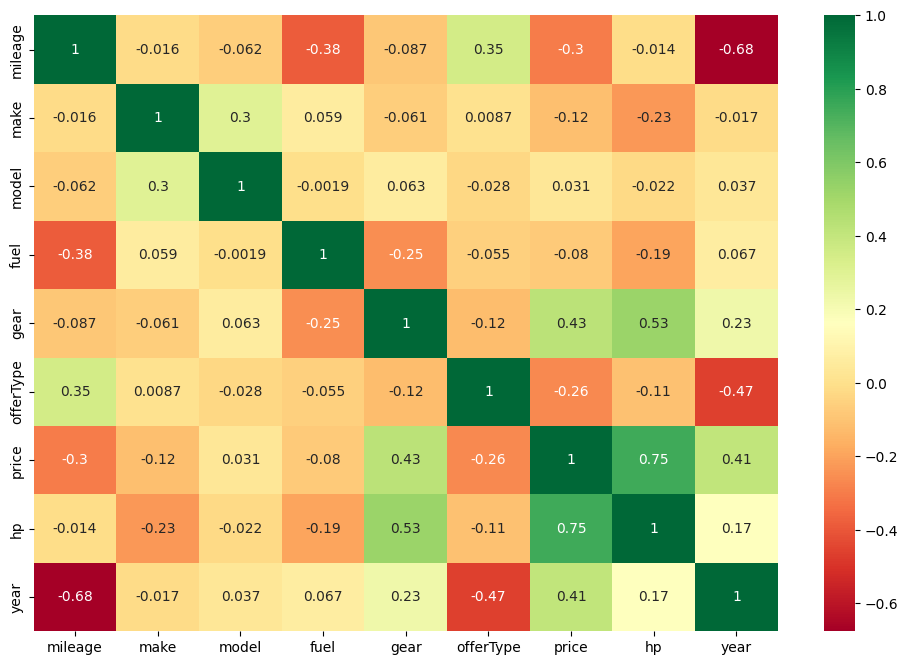

In [29]:
from sklearn.preprocessing import LabelEncoder
df_copy = df.copy()

for col in ['make', 'model', 'fuel', 'offerType']:
    le = LabelEncoder()
    df_copy[col] = le.fit_transform(df_copy[col])
    
num_cols = df_copy.select_dtypes(include='number').columns

plt.figure(figsize=(12, 8))
sns.heatmap(df_copy[num_cols].corr(), annot=True, cmap='RdYlGn')
plt.show()

Видим большую корреляцию на признаке hp(0.75). Можно убрать этот признак.

In [30]:
df = df[df.columns.drop('hp')]

Нам хотелось бы изменить признак offerType, там слишком много лишнего, можно сузить все до новое и б/у.

Так же можно подкорректировать признак fuel.

# Корректировка offerType

New, Pre-registered, Demonstration мы будем считать новыми, остальные будут б/у.

Эти значения мы представим как 0 - новые, 1 - б/у.

In [31]:
df.loc[df['offerType'] == 'New', 'offerType'] = 0 
df.loc[df['offerType'] == 'Demonstration', 'offerType'] = 0
df.loc[df['offerType'] == 'Pre-registered', 'offerType'] = 0
df.loc[df['offerType'] == 'Used', 'offerType'] = 1 
df.loc[df['offerType'] == "Employee's car", 'offerType'] = 1 

In [32]:
df['offerType'].value_counts()

offerType
1    41115
0     5146
Name: count, dtype: int64

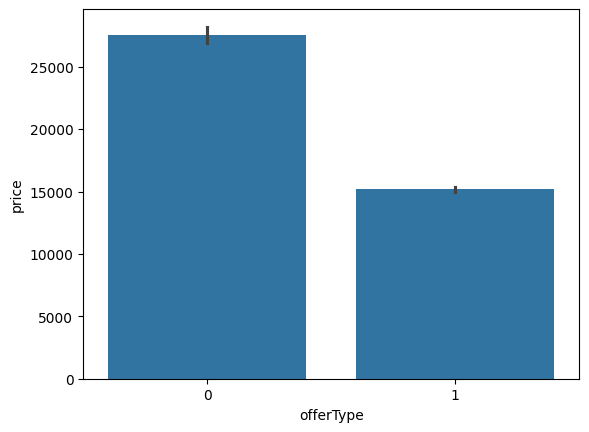

In [33]:
sns.barplot(x = "offerType", y = "price", data = df);

Видим, что естественно новые авто дороже.

# Корректировка fuel

In [34]:
df['fuel'].unique()

array(['Diesel', 'Gasoline', 'Electric/Gasoline', 'Electric',
       'Electric/Diesel', 'CNG', 'LPG', 'Others', 'Hydrogen', 'Ethanol'],
      dtype=object)

Много типов топлива, можно сократить до безина, дизеля, гибрид, элекричество, и другое.

In [35]:
df.loc[df['fuel'] == 'Electric/Gasoline', 'fuel'] = 'Hybrid'
df.loc[df['fuel'] == 'Electric/Diesel', 'fuel'] = 'Hybrid'
df.loc[df['fuel'] == 'CNG', 'fuel'] = 'Others'
df.loc[df['fuel'] == 'LPG', 'fuel'] = 'Others'
df.loc[df['fuel'] == 'Hydrogen', 'fuel'] = 'Others'
df.loc[df['fuel'] == 'Ethanol', 'fuel'] = 'Others'

In [36]:
df['fuel'].unique()

array(['Diesel', 'Gasoline', 'Hybrid', 'Electric', 'Others'], dtype=object)

Посмотрим зависимость цены от вида топлива.

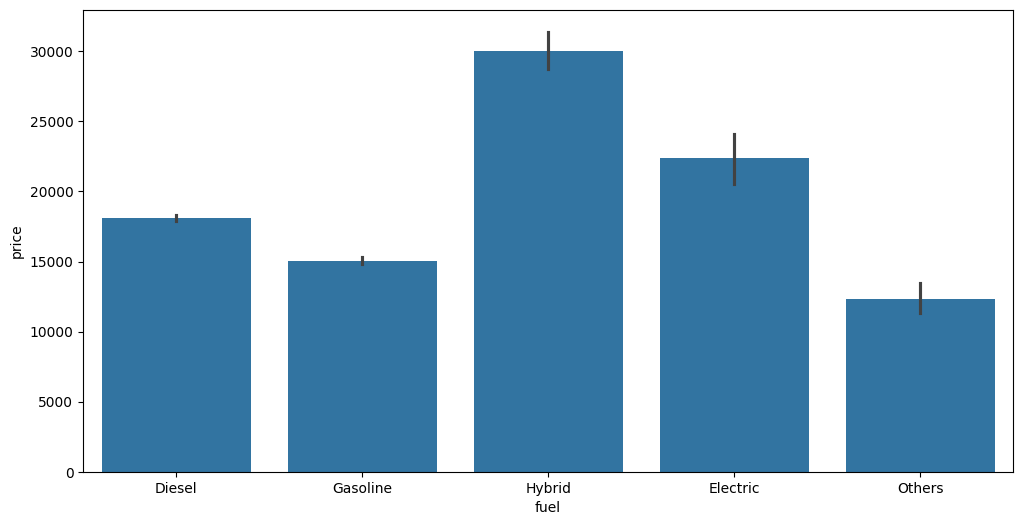

In [37]:
plt.figure(figsize=(12, 6))
sns.barplot(x = "fuel", y = "price", data = df);

## Еще раз посмотрим корреляцию

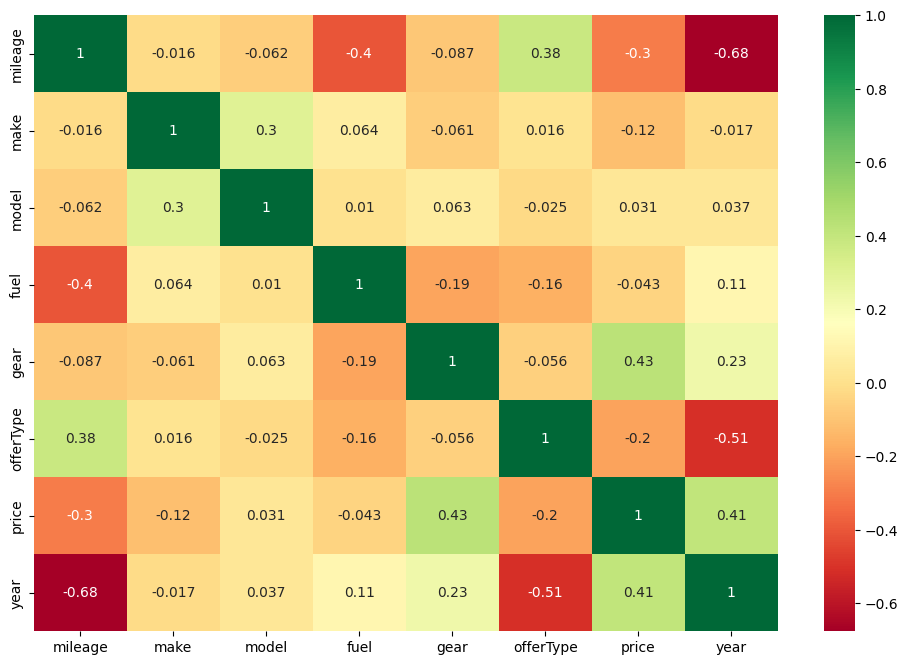

In [39]:
df_copy = df.copy()

for col in ['make', 'model', 'fuel', 'offerType']:
    le = LabelEncoder()
    df_copy[col] = le.fit_transform(df_copy[col])
    
num_cols = df_copy.select_dtypes(include='number').columns

plt.figure(figsize=(12, 8))
sns.heatmap(df_copy[num_cols].corr(), annot=True, cmap='RdYlGn')
plt.show()

Теперь высокой корреляции нет.